### Demo Notebook

This notebook helps you to load specific models for heart rate estimation from videos

In [1]:
import pathlib
from aifc import Error
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from scipy.signal import butter
import scipy

import sys
sys.path.append("./code")
from inference_preprocess import preprocess_raw_video_, detrend
from model import CAN_3D,Hybrid_CAN
from pre_process import get_nframe_video, split_subj_, sort_video_list_, sort_dataFile_list_


from pathlib import Path
from glob import glob
from scipy import signal
import pickle

2022-12-22 16:36:42.631226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bhargav/anaconda3/envs/pyvhr/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-22 16:36:42.631328: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


There are two architectures available (CAN_3D and Hybrid_CAN) and you can select the same in the next code cell.
More information about these architectures can be found [here](https://papers.nips.cc/paper/2020/file/e1228be46de6a0234ac22ded31417bc7-Paper.pdf).

In [16]:
#Configuration for the model
img_rows = 36
img_cols = 36
frame_depth = 10
batch_size = 100

while(1):
    sm = input("Enter '3d' for CAN_3D or 'hy' for Hybrid_CAN")
    
    if sm == "3d":
        model_name = "CAN_3D"
        model_checkpoint_3d = "./checkpoints/ppg-3d-can.h5"
        model = CAN_3D(frame_depth, 32, 64, (img_rows, img_cols, frame_depth, 3))
        model.load_weights(model_checkpoint_3d)
        break
    elif sm == "hy":
        model_name = "Hybrid_CAN"
        model_checkpoint_hy = "./checkpoints/ppg-hy-can.h5"
        model = Hybrid_CAN(frame_depth, 32, 64, (img_rows, img_cols, frame_depth, 3),
                            (img_rows, img_cols, 3))
        model.load_weights(model_checkpoint_hy)
        break
    else:
        print("Please select a valid input")
        continue
print("Selected Model is:", model_name)

Enter '3d' for CAN_3D or 'hy' for Hybrid_CAN3d
Selected Model is: CAN_3D


In [17]:
# model_checkpoint_hy = "./models/ppg-Hybrid_CAN-4-19/cv_0_epoch02_model.tf/"
# model_checkpoint_3d = "./models/ppg-CAN_3D-4-19/cv_0_epoch02_model.tf/"

#sample data path
data_path = "/home/bhargav/processed/p1/0/HRNR_HIGH_dataFile.hdf5"

In [18]:
def prepare_3D_CAN(dXsub):
    frame_depth = 10
    num_window = int(dXsub.shape[0]) - frame_depth + 1
    tempX = np.array([dXsub[f:f + frame_depth, :, :, :] # (491, 10, 36, 36 ,6) (169, 10, 36, 36, 6)
                    for f in range(num_window)])
    tempX = np.swapaxes(tempX, 1, 3) # (169, 36, 36, 10, 6)
    tempX = np.swapaxes(tempX, 1, 2) # (169, 36, 36, 10, 6)
    return tempX

def prepare_Hybrid_CAN(dXsub):
    frame_depth = 10
    num_window = int(dXsub.shape[0]) - frame_depth + 1
    tempX = np.array([dXsub[f:f + frame_depth, :, :, :] # (169, 10, 36, 36, 6)
                        for f in range(num_window)])
    tempX = np.swapaxes(tempX, 1, 3) # (169, 36, 36, 10, 6)
    tempX = np.swapaxes(tempX, 1, 2) # (169, 36, 36, 10, 6)
    motion_data = tempX[:, :, :, :, :3]
    apperance_data = np.average(tempX[:, :, :, :, -3:], axis=-2)
    return motion_data, apperance_data

In [19]:
#load the processed data that is scaled and normalized
data = h5py.File(data_path, "r")
dXsub = np.array(data["data"])
dXsub_len = (dXsub.shape[0] // frame_depth) * frame_depth
dXsub = dXsub[:dXsub_len, :, :, :]
pulse_truth = np.array(data["pulse"])
data.close()
#FPS/sampling frequency of the ground truth data
fs = 25

# rPPG estimation of the processed video
if model_name == "CAN_3D":
    dXsub = prepare_3D_CAN(dXsub)
    dXsub_len = (dXsub.shape[0] // (frame_depth))  * (frame_depth)
    dXsub = dXsub[:dXsub_len, :, :, :,:]
    yptest = model.predict((dXsub[:, :, :,: , :3], dXsub[:, :, :, : , -3:]), verbose=1)
elif model_name == "Hybrid_CAN":
    dXsub1, dXsub2 = prepare_Hybrid_CAN(dXsub)
    dXsub_len1 = (dXsub1.shape[0] // (frame_depth*10))  * (frame_depth*10)
    dXsub1 = dXsub1[:dXsub_len1, :, :, :, :]
    dXsub_len2 = (dXsub2.shape[0] // (frame_depth*10))  * (frame_depth*10)
    dXsub2 = dXsub2[:dXsub_len2, :, :, :]
    yptest = model.predict((dXsub1, dXsub2), verbose=1)
else:
    raise NotImplementedError
    
if model_name == "CAN_3D" or model_name == "Hybrid_CAN":
    pulse_pred = yptest[:,0]       
else:
    raise NotImplementedError
        
        
def HR_estimate(input_signal):
    '''Estimate the HR using the PSD of the rPPG signal'''
    #estimating HR from the predicted rPPG signal
    pulse_pred = detrend(np.cumsum(input_signal), 100)
    [b_pulse_pred, a_pulse_pred] = butter(1, [0.75 / fs * 2, 3.5 / fs * 2], btype='bandpass')
    pulse_pred = scipy.signal.filtfilt(b_pulse_pred, a_pulse_pred, np.double(pulse_pred))

    N = 30 * fs
    pulse_fft = np.expand_dims(pulse_pred, 0)
    f, pxx = signal.periodogram(pulse_fft, fs=fs, nfft=4 * N, detrend=False)
    fmask = np.argwhere((f >= 0.75) & (f <= 3.5))  # regular Heart beat are 0.75*60 and 2.5*60
    frange = np.take(f, fmask)
    HR = np.take(frange, np.argmax(np.take(pxx, fmask), 0))[0] * 60
    return HR


HR_pred = HR_estimate(pulse_pred)
HR_truth = HR_estimate(pulse_truth)

2022-12-22 16:43:53.447776: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 230169600 exceeds 10% of free system memory.
2022-12-22 16:43:53.845075: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 230169600 exceeds 10% of free system memory.


47/47 [==============================] - 57s 584ms/step


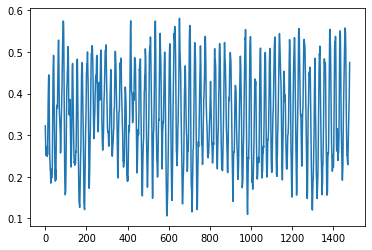

In [20]:
plt.plot(pulse_pred)

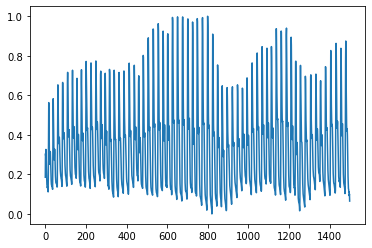

In [21]:
plt.plot(pulse_truth)

In [15]:
HR_truth, HR_pred

(61.99999999999999, 61.99999999999999)